# Data Loading and Exploration

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('booking_data.csv')  # Replace with your dataset's filename

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())

# Display the first few rows of the dataset
print("\nSample Data:")
print(data.head())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Check the distribution of the target variable (car booking status)
print("\nCar Booking Distribution:")
print(data['Car_bookingStatus'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   travelCode           40552 non-null  int64  
 1   User_ID              40552 non-null  int64  
 2   Departure            40552 non-null  object 
 3   Arrival              40552 non-null  object 
 4   flightType           40552 non-null  object 
 5   Flight_price         40552 non-null  float64
 6   Flight_duration      40552 non-null  float64
 7   Flight_Distance      40552 non-null  float64
 8   Flight_agency        40552 non-null  object 
 9   Departure_date       40552 non-null  object 
 10  Hotel_Name           40552 non-null  object 
 11  Arrival_place        40552 non-null  object 
 12  Hotel_stay           40552 non-null  int64  
 13  Hotel_per_day_price  40552 non-null  float64
 14  Check-in_hotel       40552 non-null  object 
 15  Hotel_TotalPrice     4

# Data Preprocessing

In [ ]:
# Convert Car_bookingStatus into binary format
data['car_booked'] = data['Car_bookingStatus'].apply(lambda x: 1 if x == 'Confirmed' else 0)

# Drop columns that are directly related to car booking as they can leak information
drop_columns = [
    'Check-in_car', 'pickupLocation', 'dropoffLocation', 'carType', 
    'rentalAgency', 'rentalDuration', 'Car_total_distance', 
    'fuelPolicy', 'total_rent_price', 'Car_bookingStatus'
]
data = data.drop(columns=drop_columns)

# Convert categorical features to numerical using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

# Display dataset info after preprocessing
print("\nDataset after preprocessing:")
print(data.info())

# Check updated class distribution
print("\nUpdated Car Booking Distribution:")
print(data['car_booked'].value_counts())



Dataset after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Columns: 439 entries, travelCode to Check-in_hotel_12/31/2020
dtypes: bool(430), float64(5), int64(4)
memory usage: 19.4 MB
None

Updated Car Booking Distribution:
car_booked
0    39291
1     1261
Name: count, dtype: int64


# Handling Imbalance using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(columns=['car_booked'])
y = data['car_booked']

# Split data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Before SMOTE:
car_booked
0    31432
1     1009
Name: count, dtype: int64

After SMOTE:
car_booked
0    31432
1    31432
Name: count, dtype: int64


# Train a Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.8938478609296018

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      7859
           1       0.03      0.08      0.04       252

    accuracy                           0.89      8111
   macro avg       0.50      0.50      0.49      8111
weighted avg       0.94      0.89      0.92      8111



d:\Make_my_trip\Recommendation\recomm\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model achieved 89.38% accuracy, but the classification report shows poor performance on the minority class (car_booked = 1):

Precision = 0.03 (Very low; too many false positives)
Recall = 0.08 (Misses most positive cases)
F1-score = 0.04 (Poor balance between precision and recall) 
# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding binary one-hot encoded columns)
num_cols = ['Flight_price', 'Flight_duration', 'Flight_Distance', 'Hotel_stay', 
            'Hotel_per_day_price', 'Hotel_TotalPrice']

# Initialize scaler
scaler = StandardScaler()

# Scale only numerical columns in training and test sets
X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Verify scaling
print(X_train_resampled[num_cols].head())


   Flight_price  Flight_duration  Flight_Distance  Hotel_stay  \
0      1.327021         0.796625         0.802450    0.635172   
1      1.058008         0.644402         0.640115    1.586440   
2     -0.105847         0.454124         0.447477   -0.316096   
3      1.124338         0.796625         0.802450   -0.316096   
4     -0.079956        -0.592407        -0.598410    0.635172   

   Hotel_per_day_price  Hotel_TotalPrice  
0             0.383547          0.648919  
1             1.380649          2.417496  
2             1.383357          0.301755  
3             0.383547         -0.172906  
4             0.451113          0.697035  


# Retrain Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=500)  # Increased iterations to improve convergence
log_reg.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.9206016520774257
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      7859
           1       0.03      0.05      0.04       252

    accuracy                           0.92      8111
   macro avg       0.50      0.50      0.50      8111
weighted avg       0.94      0.92      0.93      8111



d:\Make_my_trip\Recommendation\recomm\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#  Train a Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with more estimators
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0:1, 1:10})
rf_model = RandomForestClassifier(n_estimators=200, class_weight={0: 1, 1: 50}, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Model Accuracy: 0.9675748982862779
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7859
           1       0.00      0.00      0.00       252

    accuracy                           0.97      8111
   macro avg       0.48      0.50      0.49      8111
weighted avg       0.94      0.97      0.95      8111



## try the different metrics

In [ ]:
from sklearn.metrics import roc_auc_score

y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probability scores
print("AUC-ROC Score:", roc_auc_score(y_test, y_probs))


AUC-ROC Score: 0.5123056772439646


# Train XGboost Classifier

In [ ]:
from xgboost import XGBClassifier

# xgb_model = XGBClassifier(n_estimators=200, scale_pos_weight=50, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, scale_pos_weight=30, random_state=42)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89      7859
           1       0.04      0.22      0.06       252

    accuracy                           0.80      8111
   macro avg       0.50      0.52      0.47      8111
weighted avg       0.94      0.80      0.86      8111



# Fine tunning the Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [10, 20, 30]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), params, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 10}


# Feature Engineering: Identify the Most Important Features

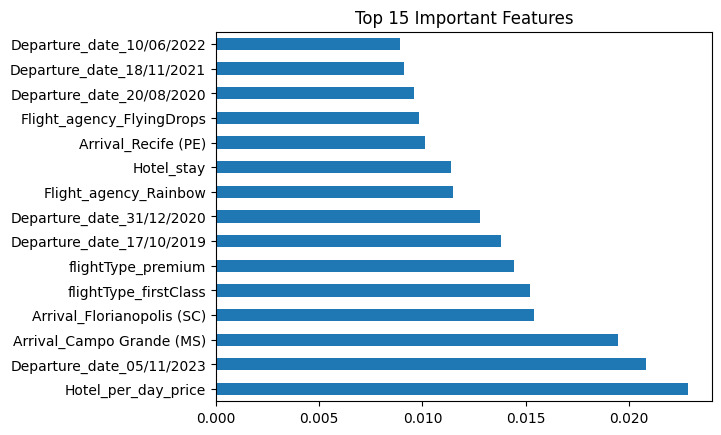

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importance.nlargest(15).plot(kind='barh')
plt.title("Top 15 Important Features")
plt.show()


# Try SMOTE + NearMiss Hybrid Sampling

In [ ]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote = SMOTE(sampling_strategy=0.5, random_state=42)
nearmiss = NearMiss(sampling_strategy=0.8)

pipeline = Pipeline([('SMOTE', smote), ('NearMiss', nearmiss)])
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)


## Retrain with the best parameters:

In [ ]:
from xgboost import XGBClassifier

# xgb_model = XGBClassifier(n_estimators=200, scale_pos_weight=50, random_state=42)
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.2, max_depth=7, scale_pos_weight=5, random_state=42)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      7859
           1       0.04      0.02      0.02       252

    accuracy                           0.96      8111
   macro avg       0.50      0.50      0.50      8111
weighted avg       0.94      0.96      0.95      8111

